In [99]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [100]:
# Consensus between two colors ("RED" and "BLUE")

class Simulator:
    END_EPOCH = 100
    
    def __init__(self, validator_num, fault_tolerance, committee_size, init_red_honest_ratio, init_red_adversary_ratio):
        self.validator_num = validator_num
        self.fault_tolerance = fault_tolerance
        self.committee_size = committee_size

        self.validator_id_list = list(range(self.validator_num))
        self.adversary_num = math.ceil(self.validator_num * self.fault_tolerance) - 1
        self.adversary_ids = set(self.validator_id_list[: adversary_num])
        self.honest_ids = set(self.validator_id_list[adversary_num:])
        assert self.validator_num == len(self.honest_ids) + len(self.adversary_ids)

        # Sets of votes
        # Assume RED has the higher score in the initial state
        self.red_honest_ids = set(random.sample(self.honest_ids, math.ceil(self.validator_num * init_red_honest_ratio))) # Honest validators voting for RED
        self.red_adversary_ids = set(random.sample(self.adversary_ids, math.ceil(self.validator_num * init_red_adversary_ratio))) # Adversarial validators voting for RED

        # Index: 0 -> RED, 1 -> BLUE
        self.votes = [{"honest_ids": self.red_honest_ids, "adversary_ids": self.red_adversary_ids},
                      {"honest_ids": self.honest_ids - self.red_honest_ids, "adversary_ids": self.adversary_ids - self.red_adversary_ids}]
                                     
        # Slot, epoch
        self.slot = 0
        self.epoch = 0
        self.slots_per_epoch = self.validator_num / self.committee_size
        self.slot_allocation = self.validator_id_list
        
        # Log for visualization
        self.pivots = np.zeros(Simulator.END_EPOCH)  # Number of pivots in the epoch
        self.scores = np.zeros(int(Simulator.END_EPOCH * self.slots_per_epoch * 2 * 2)).reshape(int(Simulator.END_EPOCH * self.slots_per_epoch), 2, 2)  # Index: slot * epoch -> honest/adversary -> red/blue
        
    def get_red_score(self):
        return len(self.votes[0]["honest_ids"]) + len(self.votes[0]["adversary_ids"])

    def get_blue_score(self):
        return len(self.votes[1]["honest_ids"]) + len(self.votes[1]["adversary_ids"])

    
    def get_winner(self):
        if self.get_red_score() > self.get_blue_score():
            return 0
        elif self.get_red_score() == self.get_blue_score() and self.votes[0]["honest_ids"] >= self.votes[1]["honest_ids"]:
            # If there is a tie, adversasy assumes the worst tie-breaking
            return 0
        return 1

    
    def get_committee(self):
        offset = int(self.committee_size * (self.slot % self.slots_per_epoch))
        return set(self.slot_allocation[offset: offset + self.committee_size])

    def batch_vote(self, target, validator_ids):
        non_target = (target + 1) % 2
        self.votes[non_target]["honest_ids"] -= validator_ids
        self.votes[non_target]["adversary_ids"] -= validator_ids
        self.votes[target]["honest_ids"] |= validator_ids & self.honest_ids
        self.votes[target]["adversary_ids"] |= validator_ids & self.adversary_ids
        assert self.votes[non_target]["honest_ids"] | self.votes[target]["honest_ids"] == self.honest_ids
        assert self.votes[non_target]["adversary_ids"] | self.votes[target]["adversary_ids"] == self.adversary_ids
        self.scores[self.slot][0][0] = len(self.votes[0]["honest_ids"])
        self.scores[self.slot][0][1] = len(self.votes[1]["honest_ids"])
        self.scores[self.slot][1][0] = len(self.votes[0]["adversary_ids"])
        self.scores[self.slot][1][1] = len(self.votes[1]["adversary_ids"])
        
    
    def decoy_flip_flop(self):
        winner = self.get_winner()
        # Adversary calculates the maximum increase of the honest votes for the winner
        # NOTE: This can be upper bounded by the number of validators who havn't voted yet and whose latest votes are not for the winner
        honest_vote_num = self.committee_size - len(self.get_committee() & self.adversary_ids)
        # Pivoting rule
        if len(self.votes[winner]["honest_ids"]) + honest_vote_num > math.ceil(self.validator_num / 2) - 1:
            new_winner = (winner + 1) % 2
            self.batch_vote(new_winner, self.adversary_ids)
            assert self.get_winner() != winner, "Pivoting failed!"
            # Save the log
            self.pivots[self.epoch] += 1

    def process_slot(self):
        # Before this slot starts, adversary make pivot in some cases
        self.decoy_flip_flop()
        winner = self.get_winner()
        self.batch_vote(winner, self.get_committee() & self.honest_ids)
        self.slot += 1

    def process_epoch(self):
        random.shuffle(self.slot_allocation)
        self.epoch += 1
        
    def run(self):
        random.shuffle(self.slot_allocation)
        while self.epoch < Simulator.END_EPOCH:
            self.process_slot()
            if self.slot % self.slots_per_epoch == 0:
                self.process_epoch()

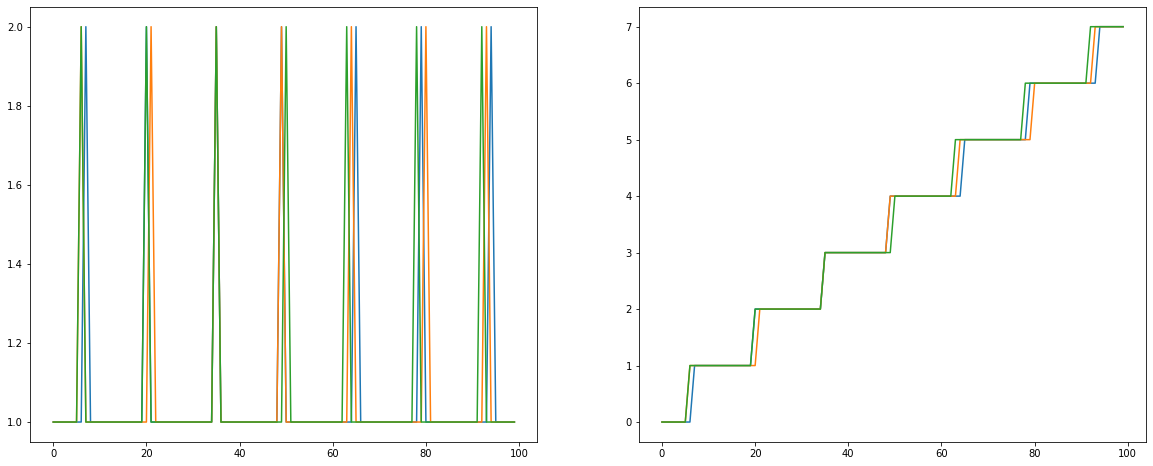

In [161]:
# Parameters
VALIDATOR_NUM = 10000
FAULT_TOLERANCE = 1/3
COMMITTEE_SIZE = 100  # VALIDATOR_NUM % COMMITTEE_SIZE == 0

INIT_RED_HONEST_RATIO = 1/3  # Must be < 1/2
INIT_RED_ADVERSARY_RATIO = 1/4  # Must be < FAULT_TOLERANCE

%matplotlib inline
# Experiment
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
for i in range(3):
    s = Simulator(VALIDATOR_NUM, FAULT_TOLERANCE, COMMITTEE_SIZE, INIT_RED_HONEST_RATIO, INIT_RED_ADVERSARY_RATIO)
    s.run()    
    ax1.plot(s.pivots)
    ax2.plot(np.vectorize(lambda x: x - 1)(s.pivots).cumsum())

<BarContainer object of 2 artists>

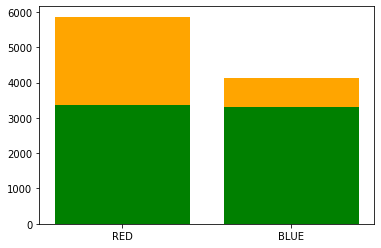

In [189]:
%matplotlib inline
plt.bar(["RED", "BLUE"], s.scores[0][0], color="green")
plt.bar(["RED", "BLUE"], s.scores[0][1], bottom=s.scores[0][0], color="orange")

matplotlib.container.BarContainer

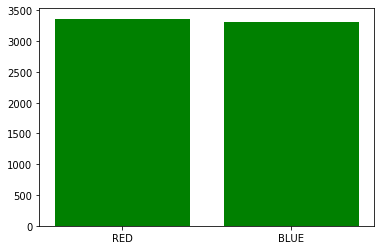

In [181]:
type(plt.bar(["RED", "BLUE"], s.scores[0][0], color="green"))

<IPython.core.display.Javascript object>


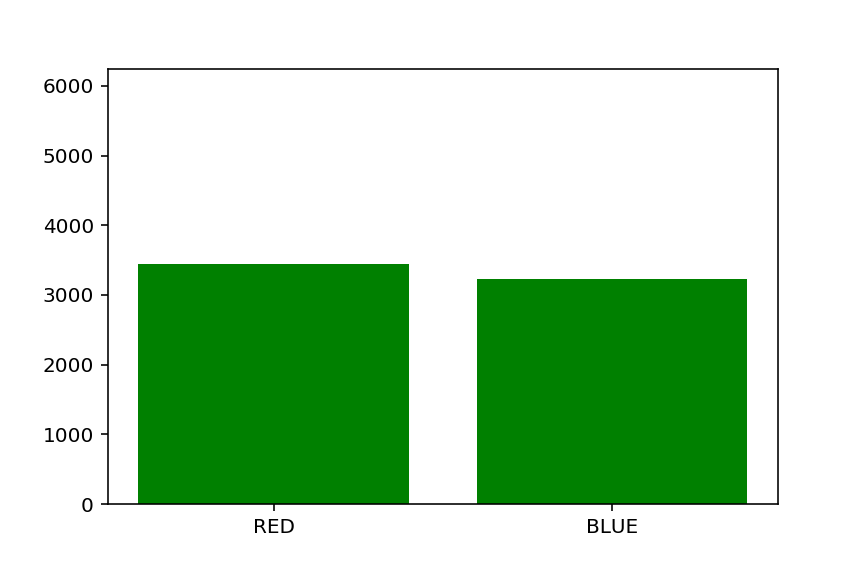

In [186]:
%matplotlib nbagg
fig = plt.figure()
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ims = []
for data in s.scores[:3]:
    p1 = plt.bar(["RED", "BLUE"], data[0], color="green")
    p2 = plt.bar(["RED", "BLUE"], data[1], bottom=data[0], color="orange")
    # Ref: https://stackoverflow.com/questions/34372021/python-matplotlib-animate-bar-and-plot-in-one-picture?rq=1
    ims.extend([p1, p2])

ani = animation.ArtistAnimation(fig, ims, interval=100)
# ani = animation.FuncAnimation(fig, plot, interval=100)

In [ ]:
%matplotlib nbagg
fig = plt.figure()
# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ims = []
for data in s.scores[:500]:
    im = plt.stackplot([0, 1], data[0], data[1], colors=['green','orange'])
    ims.append(im)

ani = animation.ArtistAnimation(fig, ims, interval=100)
# ani = animation.FuncAnimation(fig, plot, interval=100)